# DATA ANALYSIS

In [3]:
#Computation
import warnings
import numpy as np
import pandas as pd
import sklearn as skl
import scipy as sp
import re
import math
import os
import time
import gc

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
from collections import defaultdict
from tqdm import tqdm

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tools import add_constant
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from Bio import SeqIO
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from decimal import *
getcontext().prec = 20

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from adjustText import adjust_text
from matplotlib_venn import venn2
from matplotlib_venn import venn3

#Style
sns.set(style="white")
sns.set_palette('Paired')
%matplotlib inline

# Data

In [4]:
#-------------------------- MATCH FOLDER NAME TO YOUR DIRECTORY CONTAINING PROCESSED DATA ----------------------------------#
folder_name = "data_processing_240525_1828"
#---------------------------------------------------------------------------------------------------------------------------#

# figures will also be saved here in a subfolder
full_path = os.path.join("data_computed", folder_name)
full_path_figures = os.path.join("data_computed", folder_name, "figures")
os.makedirs(full_path_figures, exist_ok=True)

# write parameters used for this analysis to file
params_path = os.path.join(full_path, "parameters.txt")

# read computed files
dat_omics = pd.read_csv(os.path.join(full_path, "omics.txt"), sep="\t")
dat_vep_omics = pd.read_csv(os.path.join(full_path, "vep_omics.txt"), sep="\t")
dat_omics_mt = pd.read_csv(os.path.join(full_path, "omics_mt.txt"), sep="\t", low_memory=False)

dat_lrt = pd.read_csv(os.path.join(full_path, "lrt.txt"), sep="\t")

#This one is only needed for the sample figure
df_batch_counts = pd.read_csv(os.path.join(full_path, "batch_counts.txt"), sep="\t")

# Parameters

In [5]:
# function to read parameters used for data processing from file
def read_parameter(parameter):
    with open(os.path.join(full_path, "parameters.txt"), 'r') as f:
        for line in f:
            # Check if 'min_pdockq' is in the line
            if parameter in line:
                # Split the line on ': ' and strip any whitespace or newline characters
                _, value = line.split(': ')
                # Convert the value to float
                return float(value.strip())

In [6]:
min_pdockq = read_parameter("min_pdockq")
correlation_cutoff = read_parameter("correlation_cutoff")

print("-------------------------------------------------")
print("Current values of pDockQ and correlation cutoffs:")
print(f"Min. pDockQ: {min_pdockq}")
print(f"Min. RNA-Px correlation: {correlation_cutoff}")
print("-------------------------------------------------")

-------------------------------------------------
Current values of pDockQ and correlation cutoffs:
Min. pDockQ: 0.23
Min. RNA-Px correlation: -1.0
-------------------------------------------------


In [7]:
#-------------------------------------------------------- PARAMETER --------------------------------------------------------#
# re-define correlation_cutoff for analysis
correlation_cutoff = 0.3

# define minimum interface size
min_res = 0
#---------------------------------------------------------------------------------------------------------------------------#

dat_lrt = dat_lrt[(dat_lrt['NumRes_A']>min_res)&(dat_lrt['NumRes_B']>min_res)]

meta NOT subset; don't know how to subset; dropped


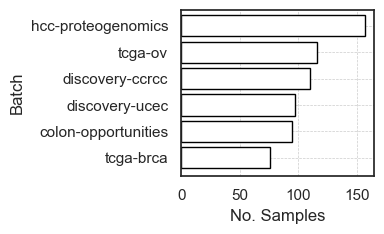

In [8]:
plt.figure(figsize=(4, 2.5))

sns.barplot(data=df_batch_counts, x='count', y='batch', color='white', edgecolor="black")

plt.ylim(5.7, -0.6)

plt.xlabel("No. Samples")
plt.ylabel("Batch")

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['svg.fonttype'] = 'none'
figure_path = os.path.join(full_path_figures, f"pQTL_suppl_batch_counts.pdf")
plt.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight')
plt.show()

# Utils

In [9]:
# function to add jitter to discrete cnv values
def add_jitter(arr, amount=0.2):
    jitter = amount * (np.random.rand(len(arr)) - 0.5)
    return arr + jitter

# Function to compute relative amino acid abundance
def compute_relative_abundance(sequence):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    total_length = len(sequence)
    relative_abundance = {aa: sequence.count(aa) / total_length for aa in amino_acids}
    return relative_abundance

# Function to convert thresholded p values into asterisks
def get_asterisks(p_val):
    if p_val < 0.001:
        return '***'
    elif p_val < 0.01:
        return '**'
    elif p_val < 0.05:
        return '*'
    else:
        return ''
    
# Function to assign amino acids to groups
def assign_group(aa):
    for group, aas in groups.items():
        if aa in aas:
            return group

In [10]:
# FDR cutoff
#-------------------------------------------------------- PARAMETER --------------------------------------------------------#
fdr_alpha = 0.01

with open(params_path, 'a') as f:
    f.write('\n')
    f.write(f"fdr_alpha: {fdr_alpha}\n")
#---------------------------------------------------------------------------------------------------------------------------#

### Basic correlations

In [11]:
# controlled gene on y axis
gene_A = 'TRMT61A'
omics_A = 'value_px'
label_A = 'Protein'
# controlling gene on x axis
gene_B = 'TRMT6'
omics_B = 'value_cnv'
label_B = 'CNV'

df_omics_A = dat_omics[dat_omics['gene']==gene_A][['gene', 'sample', omics_A]]
df_omics_B = dat_omics[dat_omics['gene']==gene_B][['gene', 'sample', omics_B]]

In [12]:
# controlled gene on y axis
gene_A = 'TRMT61A'
omics_A = 'value_px'
label_A = 'Protein'
# controlling gene on x axis
gene_B = 'TRMT61A'
omics_B = 'value_cnv'
label_B = 'CNV'

df_omics_A = dat_omics[dat_omics['gene']==gene_A][['gene', 'sample', omics_A]]
df_omics_B = dat_omics[dat_omics['gene']==gene_B][['gene', 'sample', omics_B]]


df_omics_A.columns = ['gene_A', 'sample', 'omics_A']
df_omics_B.columns = ['gene_B', 'sample', 'omics_B']

dat_attenuation = pd.merge(df_omics_A, df_omics_B, on='sample', how='inner')

r_value, p_value = stats.pearsonr(dat_attenuation['omics_B'], dat_attenuation['omics_A'])

print(f'{omics_B} {gene_B} - {omics_A} {gene_A} - r={round(r_value, 2)} - p={p_value}')

value_cnv TRMT61A - value_px TRMT61A - r=0.08 - p=0.03636414730380166


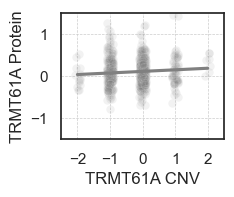

In [13]:
# if controlling cnv on x axis: add jitter
if omics_B == 'value_cnv':
    dat_attenuation['jitter_omics_B'] = add_jitter(dat_attenuation['omics_B'])
else:
    pass

plt.figure(figsize=(2.5, 2.1))

# Create the scatter plot
if omics_B == 'value_cnv':
    ax = sns.scatterplot(data=dat_attenuation, x='jitter_omics_B', y='omics_A', color='grey', alpha=0.1)
else:
    ax = sns.scatterplot(data=dat_attenuation, x='omics_B', y='omics_A', color='black', alpha=0.3)

# Pearson correlation line
sns.regplot(data=dat_attenuation, x='omics_B', y='omics_A', 
            scatter=False, color='grey', ci=None, 
            label=f"r = {r_value:.2f}\np = {p_value:.2e}")

plt.xticks([-2, -1, 0, 1, 2])
plt.xlim(-2.5, 2.5)
plt.ylim(-1.5, 1.5)

plt.xlabel(f'{gene_B} {label_B}')
plt.ylabel(f'{gene_A} {label_A}')

# Add grid lines at integer values
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Figure export
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['svg.fonttype'] = 'none'
figure_path = os.path.join(full_path_figures, f"pQTL_C_{gene_B}_{label_B}_{gene_A}_{label_A}_scatter.png")
plt.savefig(figure_path, dpi=300, transparent=True)

plt.show()

meta NOT subset; don't know how to subset; dropped


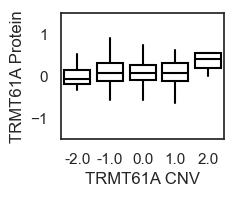

In [14]:
plt.figure(figsize=(2.5, 2.1))

# Create the scatter plot
ax = sns.boxplot(data=dat_attenuation, x='omics_B', y='omics_A',
                 showcaps=False, boxprops={'facecolor':(1, 1, 1, 0), 'edgecolor':'black'},
                 whiskerprops={'color':'black'}, medianprops={'color':'black'},
                 zorder=1, showfliers=False)

#plt.xlim(-2.4, 2.4)
plt.ylim(-1.5, 1.5)

plt.xlabel(f'{gene_B} {label_B}')
plt.ylabel(f'{gene_A} {label_A}')

# Figure export
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['svg.fonttype'] = 'none'
figure_path = os.path.join(full_path_figures, f"pQTL_C_{gene_B}_{label_B}_{gene_A}_{label_A}_box.pdf")
plt.savefig(figure_path, dpi=300, transparent=True)

plt.show()

### Statistical modeling: Volcano Plot of Nested Linear Models

In [15]:
dat_lrt_copy = dat_lrt.copy()

dat_lrt_copy['beta_sig'] = dat_lrt_copy.apply(lambda row:
                                              f'p < {fdr_alpha} / CNV Beta > 0' if (row['p_LRT_adj'] < fdr_alpha and row['param_value_cnv_B'] > 0) else
                                              f'n.s. / CNV Beta > 0' if (row['p_LRT_adj'] > fdr_alpha and row['param_value_cnv_B'] > 0) else
                                              f'p < {fdr_alpha} / CNV Beta < 0' if (row['p_LRT_adj'] < fdr_alpha and row['param_value_cnv_B'] < 0) else 
                                              f'n.s. / CNV Beta < 0', axis=1)

order_list = [f'p < {fdr_alpha} / CNV Beta > 0', f'n.s. / CNV Beta > 0', f'p < {fdr_alpha} / CNV Beta < 0', f'n.s. / CNV Beta < 0']

n_pos_ns = dat_lrt_copy[dat_lrt_copy['beta_sig'] == f'n.s. / CNV Beta > 0'].shape[0]
n_pos_s = dat_lrt_copy[dat_lrt_copy['beta_sig'] == f'p < {fdr_alpha} / CNV Beta > 0'].shape[0]
n_neg_ns = dat_lrt_copy[dat_lrt_copy['beta_sig'] == f'n.s. / CNV Beta < 0'].shape[0]
n_neg_s = dat_lrt_copy[dat_lrt_copy['beta_sig'] == f'p < {fdr_alpha} / CNV Beta < 0'].shape[0]

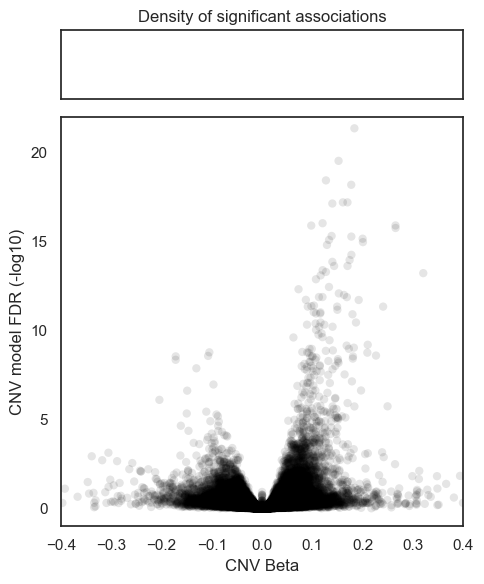

In [16]:
# Create two subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [1, 6]}, figsize=(5, 6))

# Interesting pairs to highlight in the plot
interesting_pairs = [['TRMT61A', 'TRMT6']]

ax2.scatter(dat_lrt_copy['param_value_cnv_B'], dat_lrt_copy['neg_log10_p_LRT_adj'], 
            color='black', alpha = 0.1, edgecolor='none')


xlim_volcano = 0.4

# Set the x limits
ax2.set_xlim(-xlim_volcano, xlim_volcano)
ax2.set_ylim(-1, 22)

ax2.set_ylabel("CNV model FDR (-log10)")

# Move the x-axis label to the scatter plot
ax2.set_xlabel("CNV Beta")

# Add title to the density plot
ax1.set_title("Density of significant associations")

# Remove y-axis for the density plot
ax1.yaxis.set_visible(False)

# Figure export
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['svg.fonttype'] = 'none'
figure_path = os.path.join(full_path_figures, f"pQTL_A_scatter.png")
plt.savefig(figure_path, dpi=1000, transparent=True, bbox_inches='tight', pad_inches=0)

plt.show()

meta NOT subset; don't know how to subset; dropped


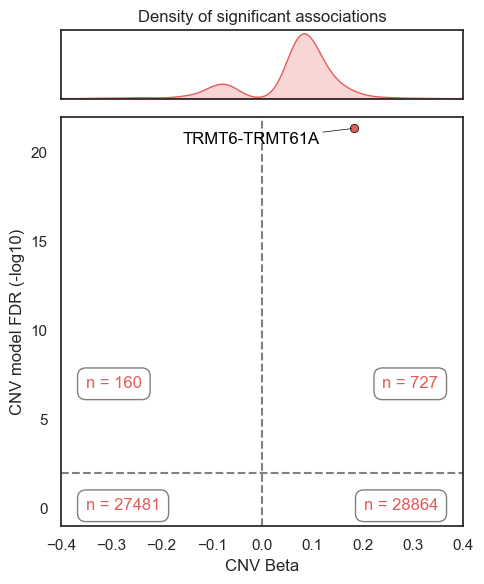

In [17]:
# Interesting pairs to highlight in the plot
interesting_pairs = [['TRMT61A', 'TRMT6'], ['ITGAV', 'ITGB3']]

# Create two subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [1, 6]}, figsize=(5, 6))

# Add vertical and horizontal lines
ax2.axvline(x=0, color='grey', linestyle='--')
ax2.axhline(y=-np.log10(fdr_alpha), color='grey', linestyle='--')

xlim_volcano = 0.4

# Set the x limits
ax2.set_xlim(-xlim_volcano, xlim_volcano)
ax2.set_ylim(-1, 22)

ax2.set_ylabel("CNV model FDR (-log10)")

# Move the x-axis label to the scatter plot
ax2.set_xlabel("CNV Beta")

# Initialize list to store the texts for adjusting later
texts = []

# Loop over the interesting pairs and annotate them on the plot
for pair in interesting_pairs:
    data_pair = dat_lrt_copy[(dat_lrt_copy['gene_A'] == pair[0]) & (dat_lrt_copy['gene_B'] == pair[1])]
    if not data_pair.empty:  # check if the pair exists in the data
        # Add a scatterplot for the pair
        plt.scatter(data_pair['param_value_cnv_B'], data_pair['neg_log10_p_LRT_adj'],
                    color='#e55c5c', alpha=1, edgecolor='black', linewidth=0.5)
        texts.append(plt.text(data_pair['param_value_cnv_B'].values[0], data_pair['neg_log10_p_LRT_adj'].values[0],
                              f'{pair[1]}-{pair[0]}', ha='left', va='top', color='black', fontsize=12))

# Adjust the texts to minimize overlaps
adjust_text(texts, force_points=0.1, force_text=0.2,
            expand_points=(1.5, 1.5), expand_text=(1.5, 1.5), 
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

# Add density plot on the top subplot (ax1) with black color
sns.kdeplot(data=dat_lrt_copy[dat_lrt_copy['p_LRT_adj']<fdr_alpha], x='param_value_cnv_B', ax=ax1, fill=True, color='#e55c5c')

# Add title to the density plot
ax1.set_title("Density of significant associations")

# Remove y-axis for the density plot
ax1.yaxis.set_visible(False)

plt.text(-(xlim_volcano-0.05), 0.15, f'n = {n_neg_ns}',
         ha='left', va='center', fontsize=12, color='#e55c5c',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))

plt.text((xlim_volcano-0.05), 0.15, f'n = {n_pos_ns}',
         ha='right', va='center', fontsize=12, color='#e55c5c',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))

plt.text(-(xlim_volcano-0.05), 7, f'n = {n_neg_s}',
         ha='left', va='center', fontsize=12, color='#e55c5c',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))

plt.text((xlim_volcano-0.05), 7, f'n = {n_pos_s}',
         ha='right', va='center', fontsize=12, color='#e55c5c',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))


# Figure export
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['svg.fonttype'] = 'none'
figure_path = os.path.join(full_path_figures, f"pQTL_A_annotation.pdf")
plt.savefig(figure_path, dpi=1000, transparent=True, bbox_inches='tight', pad_inches=0)

plt.show()

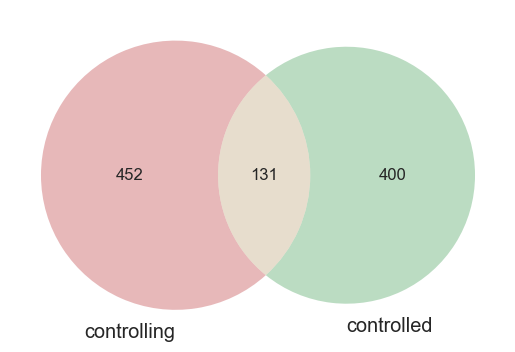

In [18]:
dat_pos_sig = dat_lrt_copy[dat_lrt_copy['beta_sig'] == f'p < {fdr_alpha} / CNV Beta > 0']
pos_sig_controlled = dat_pos_sig['gene_A'].tolist()
pos_sig_controlling = dat_pos_sig['gene_B'].tolist()
venn2([set(pos_sig_controlled), set(pos_sig_controlling)], set_labels=['controlling', 'controlled'])
#--> pretty venn diagram at eulerr.co

meta NOT subset; don't know how to subset; dropped


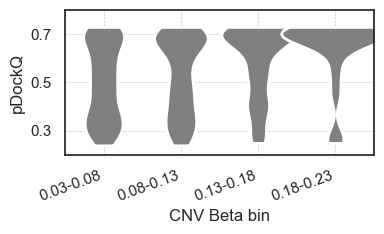

In [19]:
dat_plot = dat_pos_sig.copy()

min_beta = 0.03 
max_beta = 0.23
bin_size = 0.05

#min_beta = 0.00 
#max_beta = 0.21
#bin_size = 0.03

# Filter the DataFrame to only include values above min_beta
dat_plot = dat_plot[(dat_plot['param_value_cnv_B'] >= min_beta) & (dat_plot['param_value_cnv_B'] < max_beta)]

# Create bins from min_beta to max_beta
bins = np.arange(start=min_beta, stop=max_beta + bin_size, step=bin_size)  # Include max_beta

# Assign each value to a bin
dat_plot['param_value_cnv_B_bin'] = pd.cut(dat_plot['param_value_cnv_B'], bins=bins, include_lowest=True, right=False)

# Define the custom color palette
custom_palette = reversed(['#e55c5c', '#ed7571', '#f38d88', '#f8a49e', '#fcbbb6', '#ffd2ce'])
custom_palette = ['white', 'white', 'white', 'white', 'white', 'white']
custom_palette = ['grey', 'grey', 'grey', 'grey', 'grey', 'grey']

# Make the violin plot with the custom color palette
plt.figure(figsize=(4, 2.5))
ax = sns.violinplot(data=dat_plot, x='param_value_cnv_B_bin', y='pDockQ', 
                    palette=custom_palette, width=1.4,
                    inner=None, linewidth=2, bw=0.3, cut=0)

for violin in ax.collections:
    violin.set_edgecolor('white')

# Generate x-tick labels using the bins array
xticklabels = [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins)-1)]

# Set the x-tick labels
ax.set_xticklabels(xticklabels, rotation=20, ha='right')

# Add grid lines for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add horizontal grid lines at specific pDockQ values
grid_values = np.arange(0.3, 0.8, 0.2)
ax.set_yticks(grid_values)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, axis='x')

plt.ylim(0.2, 0.8)

plt.xlabel("CNV Beta bin")

# Figure export settings
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['svg.fonttype'] = 'none'
figure_path = os.path.join(full_path_figures, "pQTL_D_violin.pdf")
plt.savefig(figure_path, dpi=300, transparent=True)

# Show the plot
plt.show()

In [20]:
# Count the number of observations in each bin
bin_counts = dat_plot['param_value_cnv_B_bin'].value_counts().sort_index()

# Printing the counts
print("Number of observations per bin:")
print(bin_counts)

Number of observations per bin:
param_value_cnv_B_bin
[0.03, 0.08)    266
[0.08, 0.13)    346
[0.13, 0.18)     86
[0.18, 0.23)     19
Name: count, dtype: int64


In [21]:
r_value, p_value = stats.pearsonr(dat_pos_sig['param_value_cnv_B'], dat_pos_sig['pDockQ'])
print(f"Correlation of CNV Beta and pDockQ for significant associations with positive CNV Betas:")
print(f"r = {round(r_value, 2)}")
print(f"p = {p_value}")

Correlation of CNV Beta and pDockQ for significant associations with positive CNV Betas:
r = 0.15
p = 3.1251721665176513e-05


meta NOT subset; don't know how to subset; dropped


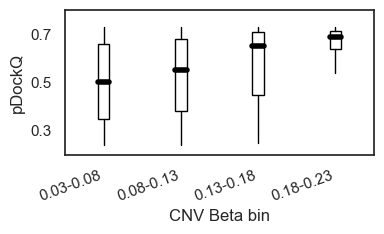

In [22]:
dat_plot = dat_pos_sig.copy()

# Filter the DataFrame to only include values above min_beta
dat_plot = dat_plot[(dat_plot['param_value_cnv_B'] >= min_beta) & (dat_plot['param_value_cnv_B'] < max_beta)]

# Create bins from min_beta to max_beta
bins = np.arange(start=min_beta, stop=max_beta + bin_size, step=bin_size)  # Include max_beta

# Assign each value to a bin
dat_plot['param_value_cnv_B_bin'] = pd.cut(dat_plot['param_value_cnv_B'], bins=bins, include_lowest=True, right=False)

plt.figure(figsize=(4, 2.5))
ax = sns.boxplot(data=dat_plot, x='param_value_cnv_B_bin', y='pDockQ', 
                 width=0.15, linewidth=1, fliersize=0,
                 boxprops=dict(facecolor="white", edgecolor="black"),
                 medianprops=dict(color="black", linewidth=4),
                 whiskerprops=dict(color="black"), 
                 capprops=dict(linestyle="none"))

# Generate x-tick labels using the bins array
xticklabels = [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins)-1)]
#xticklabels = [f"{bins[i]:.2f}" for i in range(len(bins)-1)]

# Set the x-tick labels
ax.set_xticklabels(xticklabels, rotation=20, ha='right')

# Invert y-axis
#ax.invert_yaxis()

# Add horizontal grid lines at specific pDockQ values
grid_values = np.arange(0.3, 0.8, 0.2)
ax.set_yticks(grid_values)


plt.ylim(0.2, 0.8) 

plt.xlabel("CNV Beta bin")

# Figure export settings
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['svg.fonttype'] = 'none'
figure_path = os.path.join(full_path_figures, "pQTL_D_box.pdf")
plt.savefig(figure_path, dpi=300, transparent=True)

# Show the plot
plt.show()

# Attenuation strength vs. relative interface size

In [23]:
dat_lrt_copy = dat_lrt.copy()

# Determine whether to plot controlled (frac_A) or controlling (frac_B) (try both!)
#-------------------------------------------------------- PARAMETER --------------------------------------------------------#
ixn_score = 'frac_A'
ixn_score = 'frac_B'
min_cnv_beta = 0
#---------------------------------------------------------------------------------------------------------------------------#

if ixn_score =='frac_A':
    ctrl = 'Controlled'
    color = "#ffce5d"
else:
    ctrl = 'Controlling'
    color = "#2455db"

# Only consider positive CNV Betas
dat_lrt_copy = dat_lrt_copy[dat_lrt_copy['param_value_cnv_B']>min_cnv_beta]

# Adjust LRT p-values for false discovery rate using the Benjamini-Hochberg method
dat_lrt_copy['p_LRT_adj'] = multipletests(dat_lrt_copy['p_LRT'].dropna().values, method='fdr_bh')[1]

#Only look at significant hits
dat_lrt_copy = dat_lrt_copy[dat_lrt_copy['p_LRT_adj']<fdr_alpha]

# Count the number of characters in sequence_A and save it to NumSeq_A column
dat_lrt_copy['NumSeq_A'] = dat_lrt_copy['sequence_A'].str.len()
dat_lrt_copy['frac_A'] = dat_lrt_copy['NumRes_A']/dat_lrt_copy['NumSeq_A']

# Count the number of characters in sequence_B and save it to NumSeq_B column
dat_lrt_copy['NumSeq_B'] = dat_lrt_copy['sequence_B'].str.len()
dat_lrt_copy['frac_B'] = dat_lrt_copy['NumRes_B']/dat_lrt_copy['NumSeq_B']

#Compute correlation
correlation, p_value = stats.pearsonr(dat_lrt_copy['param_value_cnv_B'], dat_lrt_copy[ixn_score])

In [24]:
# Determine limits of plots (ignore outliers for plotting (still included in computations of correlations))

#----------------------------------------------------PLOTTING PARAMETER-----------------------------------------------------#
xlim_frac = 0.23
ylim_frac = 0.52
#dat_lrt_copy = dat_lrt_copy[(dat_lrt_copy['param_value_cnv_B']<=xlim_frac) & (dat_lrt_copy[ixn_score]<=ylim_frac)]
#---------------------------------------------------------------------------------------------------------------------------#

meta NOT subset; don't know how to subset; dropped


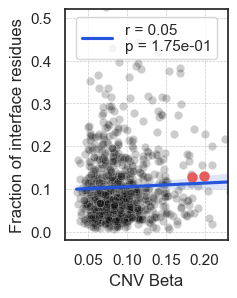

In [25]:
plt.figure(figsize=(2.1, 3))

# Plot without density map
sns.scatterplot(data=dat_lrt_copy, x='param_value_cnv_B', y=ixn_score, color='black', alpha=0.2)

sns.regplot(data=dat_lrt_copy, x='param_value_cnv_B', y=ixn_score, 
            scatter=False, color=color,
            label=f"r = {correlation:.2f}\np = {p_value:.2e}")

# Legend at the top center
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1))

plt.xlabel("CNV Beta")
plt.ylabel(f"Fraction of interface residues")

# Add grid lines at integer values
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Set x and y-axis limits
plt.xlim([0.02, xlim_frac])
plt.ylim([-0.02, ylim_frac])

plt.xticks(np.arange(0.05, xlim_frac + 0.01, 0.05))

# Color interesting pairs
interesting_pairs = [['TRMT61A', 'TRMT6'], 
                     ['GATC', 'QRSL1']]

# Loop over the interesting pairs and annotate them on the plot
for pair in interesting_pairs:
    data_pair = dat_lrt_copy[(dat_lrt_copy['gene_A'] == pair[0]) & 
                             (dat_lrt_copy['gene_B'] == pair[1])]
    plt.scatter(data_pair['param_value_cnv_B'], data_pair[ixn_score],
                color='#e55c5c', alpha=1, linewidth=1.5)

# Figure export
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['svg.fonttype'] = 'none'
figure_path = os.path.join(full_path_figures, f"pQTL_E_{ctrl}.pdf")
plt.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight')

plt.show()

In [26]:
# For supplementary table: Export positive/significant interaction pairs
dat_lrt_copy = dat_lrt.copy()

# Count the number of characters in sequence_A and save it to NumSeq_A column
dat_lrt_copy['NumSeq_A'] = dat_lrt_copy['sequence_A'].str.len()
dat_lrt_copy['frac_A'] = dat_lrt_copy['NumRes_A']/dat_lrt_copy['NumSeq_A']

# Count the number of characters in sequence_B and save it to NumSeq_B column
dat_lrt_copy['NumSeq_B'] = dat_lrt_copy['sequence_B'].str.len()
dat_lrt_copy['frac_B'] = dat_lrt_copy['NumRes_B']/dat_lrt_copy['NumSeq_B']

dat_pos_sig = dat_lrt_copy[(dat_lrt_copy['param_value_cnv_B']>0) & 
                           (dat_lrt_copy['p_LRT_adj']<fdr_alpha)]
dat_pos_sig_exp = dat_pos_sig[['gene_A', 'gene_B', 'param_value_cnv_B', 'p_LRT_adj', 'pDockQ', 
                               'NumRes_A', 'NumRes_B', 'NumSeq_A', 'NumSeq_B', 'frac_A', 'frac_B']]

file_path = os.path.join(full_path_figures, f'pQTL_A_all_ctrl_ixn_fdr_{fdr_alpha}.tsv')
dat_pos_sig_exp.to_csv(file_path, sep="\t", index=False)

## Sensitivity Analysis

In [27]:
# Define parameter ranges
pdockq_range = np.arange(dat_lrt['pDockQ'].min(), dat_lrt['pDockQ'].max(), 0.01)
ixn_scores = ['frac_A', 'frac_B']

# Initialize results dataframe
results = pd.DataFrame(columns=['pdockq_min', 'ixn_score', 'correlation', 'p_value'])

   
for pdockq_min in pdockq_range:
    for ixn_score in ixn_scores:

        #Filter dat_lrt
        filtered_data = dat_lrt[(dat_lrt['param_value_cnv_B'] > 0) & 
                                (dat_lrt['pDockQ'] > pdockq_min)]
        
        filtered_data = filtered_data.copy()

        # Adjust LRT p-values for false discovery rate using the Benjamini-Hochberg method
        filtered_data['p_LRT_adj'] = multipletests(filtered_data['p_LRT'].dropna().values, 
                                                   method='fdr_bh')[1]

        # Only look at significant hits
        filtered_data = filtered_data[filtered_data['p_LRT_adj'] < fdr_alpha]

        # Compute fraction of sequences
        filtered_data['NumSeq_A'] = filtered_data['sequence_A'].str.len()
        filtered_data['frac_A'] = filtered_data['NumRes_A']/filtered_data['NumSeq_A']

        filtered_data['NumSeq_B'] = filtered_data['sequence_B'].str.len()
        filtered_data['frac_B'] = filtered_data['NumRes_B']/filtered_data['NumSeq_B']

        # Compute correlation
        correlation, p_value = stats.pearsonr(filtered_data['param_value_cnv_B'], 
                                              filtered_data[ixn_score])
        neg_log10_p_val = -np.log10(p_value)

        # Save the results to the dataframe
        results = pd.concat([results, pd.DataFrame([{
            'pdockq_min': pdockq_min, 
            'ixn_score': ixn_score, 
            'correlation': correlation, 
            'p_value': p_value}], 
            columns=['pdockq_min', 'ixn_score', 'correlation', 'p_value'])], ignore_index=True)

In [28]:
# Copy results into a new DataFrame and rename the columns
dat_plot = results.copy()
dat_plot.rename(columns={'ixn_score':'Subunit', 'ixn_set':'Database set'}, inplace=True)

# Define a color palette
palette = {"controlled": "#ffce5d", "controlling": "#2455db"}

# Replace values in the new DataFrame
dat_plot['Subunit'] = dat_plot['Subunit'].replace({'frac_A': 'controlled', 'frac_B': 'controlling'})
dat_plot['neg_log10_p_value'] = -np.log10(dat_plot['p_value'])

meta NOT subset; don't know how to subset; dropped


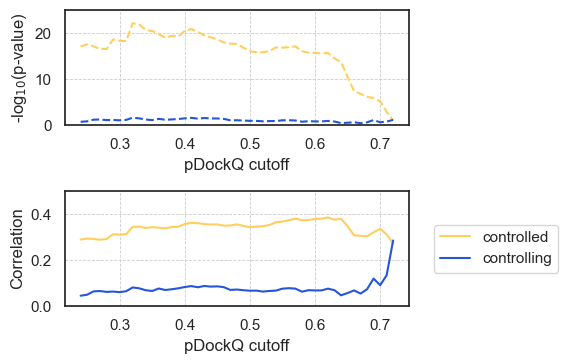

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5.9, 3.8))

# Create the first line plot for p_value without a legend
sns.lineplot(data=dat_plot, x="pdockq_min", y="neg_log10_p_value", hue="Subunit", linestyle='--',
             palette=palette, ax=axs[0], legend=False)

# Add grid lines
axs[0].grid(True, which="both", linestyle='--', linewidth=0.6)

# Set y-tick labels
axs[0].set_yticks([0, 10, 20])
axs[0].set_ylim(0, 25)

# Add title and labels
axs[0].set_xlabel("pDockQ cutoff")
axs[0].set_ylabel("-log$_{\mathrm{10}}$(p-value)")

# Create the second line plot for correlation
sns.lineplot(data=dat_plot, x="pdockq_min", y="correlation", hue="Subunit", 
             palette=palette, ax=axs[1])

# Move the legend to outside of the plot on the right
axs[1].legend(bbox_to_anchor=(1.05, 0.5), loc='center left')

# Add grid lines
axs[1].grid(True, which="both", linestyle='--', linewidth=0.6)

axs[1].set_yticks([0, 0.2, 0.4])
axs[1].set_ylim(0, 0.5)

# Add red horizontal line at y=0
#axs[1].axhline(0, color='black', linestyle="--")

# Add title and labels
axs[1].set_xlabel("pDockQ cutoff")
axs[1].set_ylabel("Correlation")

# Figure export
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['svg.fonttype'] = 'none'
figure_path = os.path.join(full_path_figures, f"pQTL_E_sensitiviy_analysis.pdf")
plt.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight')

plt.show()

# Interface composition

In [30]:
# Define threshold for cnv beta cutoff

#-------------------------------------------------------- PARAMETER --------------------------------------------------------#
cnv_beta_cutoff = 0.1
#---------------------------------------------------------------------------------------------------------------------------#

dat_lrt_copy = dat_lrt.copy()

# Compute relative abundances
dat_lrt_copy['rel_abundance_protein_A'] = dat_lrt_copy['sequence_A'].apply(compute_relative_abundance)
dat_lrt_copy['rel_abundance_interface_A'] = dat_lrt_copy['residues_A'].apply(compute_relative_abundance)

dat_lrt_copy['rel_abundance_protein_B'] = dat_lrt_copy['sequence_B'].apply(compute_relative_abundance)
dat_lrt_copy['rel_abundance_interface_B'] = dat_lrt_copy['residues_B'].apply(compute_relative_abundance)

# Subset significant control associations
dat_lrt_sig = dat_lrt_copy[dat_lrt_copy['p_LRT_adj']<fdr_alpha]

# Subset according to parameters
dat_lrt_sig_par = dat_lrt_sig[(dat_lrt_sig['param_value_cnv_B']>cnv_beta_cutoff) & 
                              (dat_lrt_sig['pDockQ']>min_pdockq)]

# Get relative abundances of controlled (A) and controlling (B) subunits
rel_abundance_controlled = dat_lrt_sig_par['rel_abundance_interface_A']
rel_abundance_controlling = dat_lrt_sig_par['rel_abundance_interface_B']

# For base abundances: subset non-significant cases with only min_pdockq
dat_lrt_ns = dat_lrt_copy[(dat_lrt_copy['p_LRT_adj']>=fdr_alpha) & 
                          (dat_lrt_copy['pDockQ']>min_pdockq)]

# Get relative abundances of one subunit (does not matter which because dataset is redundant)
rel_abundance_base = dat_lrt_ns['rel_abundance_interface_A']

# Convert the dictionary column to a DataFrame
df_rel_abundance_controlled = pd.DataFrame(list(rel_abundance_controlled))
df_rel_abundance_controlling = pd.DataFrame(list(rel_abundance_controlling))
df_rel_abundance_base = pd.DataFrame(list(rel_abundance_base))

df_melt_controlled = df_rel_abundance_controlled.melt(var_name='amino_acid', value_name='rel_abundance')
df_melt_controlled['type'] = 'controlled'

df_melt_controlling = df_rel_abundance_controlling.melt(var_name='amino_acid', value_name='rel_abundance')
df_melt_controlling['type'] = 'controlling'

df_melt_base = df_rel_abundance_base.melt(var_name='amino_acid', value_name='rel_abundance')
df_melt_base['type'] = 'base'

# Concatenate the two dataframes
df_combined = pd.concat([df_melt_controlled, df_melt_controlling, df_melt_base])

# Sort the data by the median values
df_combined_sorted = df_combined.groupby(['amino_acid','type']).median().sort_values('rel_abundance').reset_index()
sorted_amino_acids = df_combined_sorted['amino_acid'].drop_duplicates().tolist()

# Create an empty list to store the results
anova_results = []

# Loop through the unique amino acids
for aa in sorted_amino_acids:
    # Extract the rel_abundance for each amino acid for all three groups
    controlled_vals = df_combined[(df_combined['amino_acid'] == aa) & (df_combined['type'] == 'controlled')]['rel_abundance']
    controlling_vals = df_combined[(df_combined['amino_acid'] == aa) & (df_combined['type'] == 'controlling')]['rel_abundance']
    base_vals = df_combined[(df_combined['amino_acid'] == aa) & (df_combined['type'] == 'base')]['rel_abundance']
    
    # Perform the ANOVA
    f_stat, p_val = f_oneway(controlled_vals, controlling_vals, base_vals)
    
    # Store the results
    anova_results.append({'amino_acid': aa, 'f_stat': f_stat, 'p_val': p_val})

# Convert the results to a DataFrame
anova_df = pd.DataFrame(anova_results)

# Get p-values from the dataframe
pvals = anova_df['p_val'].values

# Perform FDR correction using multipletests with the method set to 'fdr_bh'
_, pval_corr, _, _ = multipletests(pvals, method='fdr_bh')

# Add corrected p-values to the dataframe
anova_df['p_val_corr'] = pval_corr

# Create an empty list to store the post-hoc results
posthoc_results = []

# Loop through the ANOVA results DataFrame
for i, row in anova_df.iterrows():
    # Check if the corrected p-value is less than alpha
    if row['p_val_corr'] < fdr_alpha:
        # Perform the post-hoc test
        tukey_results = pairwise_tukeyhsd(
            endog=df_combined[df_combined['amino_acid'] == row['amino_acid']]['rel_abundance'], 
            groups=df_combined[df_combined['amino_acid'] == row['amino_acid']]['type'], 
            alpha=0.05)
        
        # Convert the TukeyHSDResults to a DataFrame
        tukey_summary = tukey_results.summary()
        tukey_df = pd.DataFrame(tukey_summary.data[1:], columns=tukey_summary.data[0])

        # Convert columns to correct data types
        tukey_df['meandiff'] = tukey_df['meandiff'].astype(float)
        tukey_df['p-adj'] = tukey_df['p-adj'].astype(float)
        tukey_df['reject'] = tukey_df['reject'].astype(bool)

        # Filter the DataFrame to keep only the rows where reject = True
        tukey_df = tukey_df[tukey_df['reject'] == True]

        # Add the amino acid and the filtered DataFrame to the post-hoc results list
        for j, row_tukey in tukey_df.iterrows():
            posthoc_results.append({'amino_acid': row['amino_acid'], 'group1': row_tukey['group1'], 
                                    'group2': row_tukey['group2'], 'p-adj': row_tukey['p-adj']})

# Convert the post-hoc results to a DataFrame
posthoc_df = pd.DataFrame(posthoc_results)

meta NOT subset; don't know how to subset; dropped


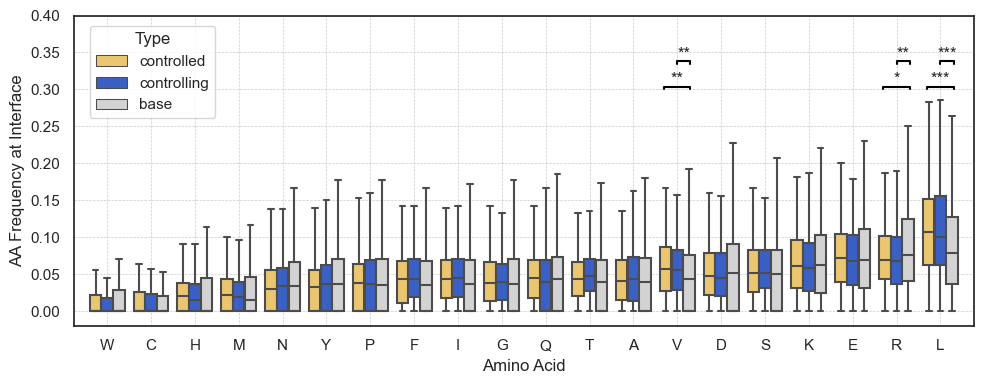

In [31]:
# Set the figure size
plt.figure(figsize=(10, 4))

custom_palette = {'controlled': '#ffce5d', 'controlling': '#2455db', 'base': 'lightgrey'}

# Create a boxplot using seaborn with removed outliers
sns.boxplot(x='amino_acid', y='rel_abundance', hue='type', data=df_combined, showfliers=False, order=sorted_amino_acids, 
            palette=custom_palette)

plt.xlabel("Amino Acid")
plt.ylabel("AA Frequency at Interface")
plt.ylim(-0.02, 0.4)  # Adjust y limits for clear visibility of annotations

group_adjust = {'controlled': -0.3, 'controlling': 0, 'base': 0.3}

# Create a dictionary to keep track of the y positions for each amino acid
y_positions = {}

# Loop through rows in posthoc_df
for i, row in posthoc_df.iterrows():
    x_location = sorted_amino_acids.index(row['amino_acid'])
    
    # Calculate the positions for group1 and group2
    x1 = x_location + group_adjust[row['group1']]
    x2 = x_location + group_adjust[row['group2']]

    # Check if the amino acid is already in the dictionary
    if row['amino_acid'] in y_positions:
        # If the amino acid is in the dictionary, increase the y position by 0.02
        y_positions[row['amino_acid']] += 0.035
    else:
        # If the amino acid is not in the dictionary, set the y position to 0.25
        y_positions[row['amino_acid']] = 0.3

    # Get the y position from the dictionary
    y_bracket = y_positions[row['amino_acid']]

    # Annotate the boxplot with brackets
    plt.plot([x1, x1, x2, x2], [y_bracket, y_bracket+0.003, y_bracket+0.003, y_bracket], lw=1.5, c='black')
    
    # Add the asterisks
    significance = get_asterisks(row['p-adj'])
    plt.text((x1 + x2) / 2, y_bracket + 0.003, significance, ha='center', va='bottom')


plt.legend(title='Type', bbox_to_anchor=(0.01, 0.99), loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Figure export
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['svg.fonttype'] = 'none'
figure_path = os.path.join(full_path_figures, f"pQTL_suppl_composition_all_AA.pdf")
plt.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight')

plt.show()

# Selected Amino Acids

meta NOT subset; don't know how to subset; dropped


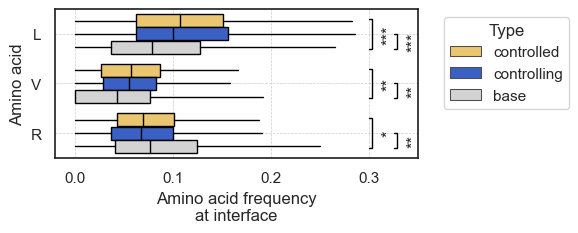

In [32]:
plt.figure(figsize=(6, 2.5))

#-------------------------------------------------------- PARAMETER --------------------------------------------------------#
selected_aa = ['L', 'V', 'R', 'D']
#---------------------------------------------------------------------------------------------------------------------------#

df_selected = df_combined[df_combined['amino_acid'].isin(selected_aa)]
selected_order = selected_aa

# Create a horizontal boxplot using seaborn with removed outliers
sns.boxplot(y='amino_acid', x='rel_abundance', hue='type', data=df_combined, showfliers=False, 
            order=selected_order, palette=custom_palette, orient='h',
            boxprops=dict(edgecolor="black", linewidth=1),
            medianprops=dict(color="black", linewidth=1),
            whiskerprops=dict(color="black", linewidth=1), 
            capprops=dict(linestyle="none"))

plt.ylabel("Amino acid") 
plt.xlabel("Amino acid frequency\nat interface")

xlim_selected = 0.35
plt.xlim(-0.02, xlim_selected)

group_adjust = {'controlled': -0.3, 'controlling': 0, 'base': 0.3}

# Create a dictionary to keep track of the x positions for each amino acid
x_positions = {}

# Loop through rows in posthoc_df
for i, row in posthoc_df.iterrows():
    y_location = selected_order.index(row['amino_acid'])
    
    # Calculate the positions for group1 and group2
    y1 = y_location + group_adjust[row['group1']]
    y2 = y_location + group_adjust[row['group2']]

    # Check if the amino acid is already in the dictionary
    if row['amino_acid'] in x_positions:
        # If the amino acid is in the dictionary, increase the x position by 0.02
        x_positions[row['amino_acid']] += 0.025
    else:
        # If the amino acid is not in the dictionary, set the x position to 0.25
        x_positions[row['amino_acid']] = 0.3

    # Get the x position from the dictionary
    x_bracket = x_positions[row['amino_acid']]

    # Annotate the boxplot with brackets
    plt.plot([x_bracket, x_bracket+0.003, x_bracket+0.003, x_bracket], 
             [y1, y1, y2, y2], lw=1, c='black')
    
    # Add the asterisks
    significance = get_asterisks(row['p-adj'])
    plt.text(x_bracket + 0.02, (y1 + y2) / 2, significance, ha='center', va='center', rotation=90)

# Updating y-tick labels
plt.ylim(2.5, -0.5)

plt.xticks(np.arange(0, xlim_selected + 0.01, 0.1))

plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Figure export
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['svg.fonttype'] = 'none'
figure_path = os.path.join(full_path_figures, f"pQTL_suppl_composition_selected_AA.pdf")
plt.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight')

plt.show()

# Variant Effect Prediction

## Explain Protein Residuals with Toy Data

In [33]:
toy_n = 20

np.random.seed(0)
toy_tx = np.random.normal(0, 0.6, toy_n)
toy_tx = toy_tx-toy_tx.mean()
noise = np.random.normal(0, 0.5, toy_tx.shape)
toy_px = toy_tx + noise
toy_px = toy_px-toy_px.mean()
toy_data = pd.DataFrame({'tx': toy_tx, 'px': toy_px})

meta NOT subset; don't know how to subset; dropped


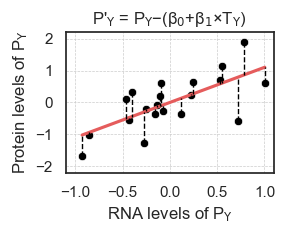

In [34]:
# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(toy_data[['tx']], toy_data['px'])

# Predict the fitted values
toy_data['fitted_px'] = model.predict(toy_data[['tx']])

# Plotting
plt.figure(figsize=(3, 2.5))
sns.regplot(data=toy_data, x='tx', y='px', color='#e55c5c', ci=None, scatter=False)
sns.scatterplot(data=toy_data, x='tx', y='px', color='black')

# Draw the residuals
for index, row in toy_data.iterrows():
    plt.plot([row['tx'], row['tx']], [row['px'], row['fitted_px']], color='black', linestyle='--', lw=1)
    
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.xlabel('RNA levels of P$_{\mathrm{Y}}$')
plt.ylabel('Protein levels of P$_{\mathrm{Y}}$')

plt.xlim(-1.1, 1.1)
plt.ylim(-2.2, 2.2)

plt.xticks(np.arange(-1, 1.1, 0.5))
plt.yticks(np.arange(-2, 2.1, 1))

# title to be used in plot
plt.title('P\'$_{\mathrm{Y}}$ = P$_{\mathrm{Y}}$−(β$_{\mathrm{0}}$+β$_{\mathrm{1}}$×T$_{\mathrm{Y}}$)')
#plt.title('pathogenic/destabilizing?')

plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['svg.fonttype'] = 'none'
figure_path = os.path.join(full_path_figures, f"stability_D_residuals.pdf")
plt.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight')

plt.show()

## Alluvial plot comparison of scores

In [35]:
dat_vep_omics_copy = dat_vep_omics.copy()
dat_vep_omics_copy = dat_vep_omics_copy[dat_vep_omics_copy['corr_value_tx_value_px']>correlation_cutoff]

# Compare FoldX, AlphaMissense, ESM1b
dat_vep_cats = dat_vep_omics_copy[['FoldX_cat', 'AM_cat', 'ESM_cat']].dropna(axis=0)
vep_counts = dat_vep_cats.groupby(['FoldX_cat', 'AM_cat', 'ESM_cat']).size().reset_index(name='count')

file_path = os.path.join(full_path_figures, 'stability_C_vep_counts_incl_ESM1b.txt')
vep_counts.to_csv(file_path, sep="\t", index=False)
#--> R

In [36]:
# Compare FoldX, AlphaMissense
dat_vep_cats = dat_vep_omics_copy[['FoldX_cat', 'AM_cat']].dropna(axis=0)
vep_counts = dat_vep_cats.groupby(['FoldX_cat', 'AM_cat']).size().reset_index(name='count')

file_path = os.path.join(full_path_figures, 'stability_C_vep_counts.txt')
vep_counts.to_csv(file_path, sep="\t", index=False)
#--> R

# Summary statistics

In [37]:
dat_vep_omics_copy = dat_vep_omics.copy()
sample_batch_info = dat_vep_omics_copy[['sample', 'batch']].drop_duplicates()
mutations_per_sample = dat_vep_omics_copy.groupby('sample').size().reset_index(name='mutations_count')

dat_plot = mutations_per_sample.merge(sample_batch_info, on='sample')

meta NOT subset; don't know how to subset; dropped


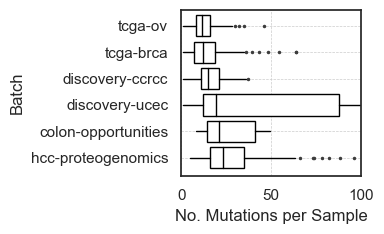

In [38]:
# Boxplots (xlim 0-100)
plt.figure(figsize=(4, 2.5))

# Calculate medians for each batch
batch_medians = dat_plot.groupby('batch')['mutations_count'].median().reset_index()

# Sort the batches by the median mutation count
sorted_batches = batch_medians.sort_values('mutations_count')['batch'].tolist()


flierprops = dict(marker='o', color='black', markersize=1.5)
# Create the violin plot with ordered batches
sns.boxplot(data=dat_plot, y='batch', x='mutations_count', order=sorted_batches, flierprops=flierprops,
                 boxprops=dict(facecolor="white", edgecolor="black", linewidth=1),
                 medianprops=dict(color="black", linewidth=1),
                 whiskerprops=dict(color="black", linewidth=1), 
                 capprops=dict(linestyle="none"))

plt.xlim(0, 100)
plt.ylim(5.7, -0.6)

plt.xlabel("No. Mutations per Sample")
plt.ylabel("Batch")

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['svg.fonttype'] = 'none'
figure_path = os.path.join(
    full_path_figures, f"stability_B_left.pdf"
)
plt.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight')

# Display the plot
plt.show()

meta NOT subset; don't know how to subset; dropped


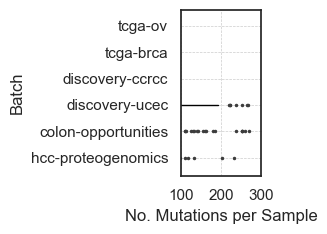

In [39]:
# Outliers (xlim 100-300)
plt.figure(figsize=(3, 2.5))

# Calculate medians for each batch
batch_medians = dat_plot.groupby('batch')['mutations_count'].median().reset_index()

# Sort the batches by the median mutation count
sorted_batches = batch_medians.sort_values('mutations_count')['batch'].tolist()


flierprops = dict(marker='o', color='black', markersize=1.5)
# Create the violin plot with ordered batches
sns.boxplot(data=dat_plot, y='batch', x='mutations_count', order=sorted_batches, flierprops=flierprops,
                 boxprops=dict(facecolor="white", edgecolor="black", linewidth=1),
                 medianprops=dict(color="black", linewidth=1),
                 whiskerprops=dict(color="black", linewidth=1), 
                 capprops=dict(linestyle="none"))

plt.xlim(100, 300)
plt.ylim(5.7, -0.6)

plt.xlabel("No. Mutations per Sample")
plt.ylabel("Batch")

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['svg.fonttype'] = 'none'
figure_path = os.path.join(full_path_figures, f"stability_B_right.pdf")
plt.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight')

# Display the plot
plt.show()

## Protein abundance in AM pathogenic, split by stability prediction (FoldX) and CNV status

In [40]:
vep_cat = 'AM_cat'

dat_vep_omics_copy = dat_vep_omics.copy()

dat_vep_omics_copy = dat_vep_omics_copy[dat_vep_omics_copy['corr_value_tx_value_px']>correlation_cutoff]

# work with AlphaMissense and FoldX predictions -> throw out NAs
dat_vep_omics_copy.dropna(subset=[vep_cat, 'FoldX_cat'], inplace=True)

# drop 'ambgiuous' AM calls
dat_vep_omics_copy = dat_vep_omics_copy[dat_vep_omics_copy[vep_cat].isin(['pathogenic', 'benign'])]

# drop 'stabilizing' FoldX calls
dat_vep_omics_copy = dat_vep_omics_copy[
    dat_vep_omics_copy['FoldX_cat'].isin(['destabilizing', 'neutral'])]

# Create a new column representing the combinations of vep_cat and 'FoldX_cat'
dat_vep_omics_copy['combination'] = dat_vep_omics_copy[vep_cat] + ' & ' +\
                                    dat_vep_omics_copy['FoldX_cat']

# drop benign & destabilizing
dat_vep_omics_copy = dat_vep_omics_copy[dat_vep_omics_copy['combination'] != 'benign & destabilizing']

# mark single copy cases
dat_vep_omics_copy['CNV'] = dat_vep_omics_copy['value_cnv'].apply(
    lambda x: 'loss' if x <= -1 else 'balanced/gain')

In [41]:
# Perform ANOVA
anova_results = f_oneway(
    dat_vep_omics_copy['residuals'][dat_vep_omics_copy['combination'] == 'pathogenic & destabilizing'],
    dat_vep_omics_copy['residuals'][dat_vep_omics_copy['combination'] == 'pathogenic & neutral'],
    dat_vep_omics_copy['residuals'][dat_vep_omics_copy['combination'] == 'benign & neutral']
)

tukey_hsd = pairwise_tukeyhsd(endog=dat_vep_omics_copy['residuals'], 
                              groups=dat_vep_omics_copy['combination'], 
                              alpha=0.05)

# Convert the Tukey HSD result table to a DataFrame for better viewing
tukey_hsd_df = pd.DataFrame(data=tukey_hsd._results_table.data[1:], 
                            columns=tukey_hsd._results_table.data[0])
tukey_hsd_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,benign & neutral,pathogenic & destabilizing,-0.0382,0.0011,-0.0635,-0.0130,True
1,benign & neutral,pathogenic & neutral,-0.0067,0.7692,-0.0296,0.0162,False
2,pathogenic & destabilizing,pathogenic & neutral,0.0315,0.0233,0.0034,0.0596,True


meta NOT subset; don't know how to subset; dropped


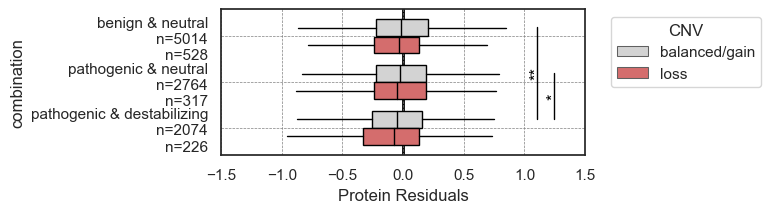

In [42]:
order = ['benign & neutral', 'pathogenic & neutral', 'pathogenic & destabilizing']
group_counts = dat_vep_omics_copy['combination'].value_counts()
group_counts_loss = dat_vep_omics_copy[dat_vep_omics_copy['CNV']=='loss']['combination'].value_counts()

# custom y-tick labels based on order
custom_yticks = [f'{label}\nn={group_counts[label]}\nn={group_counts_loss[label]}' for label in order]

# Create a figure and axes object
fig, ax = plt.subplots(figsize=(8, 2.3))

ax.axvline(x=0, color='black', linestyle='-', linewidth=2, zorder=0)

# Define a color palette
color_palette = {'balanced/gain': 'lightgrey', 'loss': '#e55c5c'}

# Create a boxplot with the order of groups
sns.boxplot(y='combination', x='residuals', hue='CNV', color='black', data=dat_vep_omics_copy, ax=ax,
            showfliers=False, width=0.75, order=order, palette=color_palette,
            boxprops=dict(edgecolor="black", linewidth=1),
            medianprops=dict(color="black", linewidth=1),
            whiskerprops=dict(color="black", linewidth=1), 
            capprops=dict(linestyle="none"))

# Set the title and labels of the plot
#plt.ylabel()
plt.xlabel('Protein Residuals')

plt.xlim(-1.5, 1.5)
plt.ylim(2.6, -0.6)

# Set custom x-tick labels with the number of observations in each group
ax.set_yticklabels(custom_yticks)

# Customize grid
ax.grid(which='major', linestyle='--', linewidth='0.5', color='gray')
ax.grid(which='minor', linestyle='--', linewidth='0.5', color='lightgray')

plt.legend(title='CNV', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add annotations for significant differences
x_max = 1
group_positions = range(len(order))
group_combinations = [(i, j) for i in group_positions for j in group_positions if i < j]

# Offset to avoid overlapping of lines
offset = 0.1

# Loop through the Tukey HSD results and add annotations for the significant differences
for (i, j) in group_combinations:
    group1 = order[i]
    group2 = order[j]
    # Get the p-value for the comparison between the two groups
    p_val = tukey_hsd_df.loc[(tukey_hsd_df['group1'] == group1) & 
                             (tukey_hsd_df['group2'] == group2), 'p-adj'].values
    if len(p_val) == 0:
        p_val = tukey_hsd_df.loc[(tukey_hsd_df['group1'] == group2) & 
                                 (tukey_hsd_df['group2'] == group1), 'p-adj'].values
    if len(p_val) > 0:
        p_val = p_val[0]
        if p_val < 0.05:
            # Add a line connecting the significant groups
            plt.plot([x_max + offset, x_max + offset], [i-0.2, j-0.2], color='black', lw=1)
            # Add asterisks representing the significance level
            plt.text(x_max + offset, (i-0.2+j-0.2)/2, get_asterisks(p_val), 
                     ha='center', va='center', color='black', fontsize=12, rotation=90)
            # Increment the offset for the next line
            offset += 0.14
                      
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['svg.fonttype'] = 'none'
figure_path = os.path.join(
    full_path_figures, f"stability_D_{vep_cat}_{correlation_cutoff}.pdf"
)
plt.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight')

plt.show()

In [43]:
vep_cat = 'AM_cat'

dat_vep_omics_copy = dat_vep_omics.copy()

# work with AlphaMissense and FoldX predictions -> throw out NAs
dat_vep_omics_copy.dropna(subset=[vep_cat, 'FoldX_cat'], inplace=True)

# drop 'ambgiuous' AM calls
dat_vep_omics_copy = dat_vep_omics_copy[dat_vep_omics_copy[vep_cat].isin(['pathogenic', 'benign'])]

# drop 'stabilizing' FoldX calls
dat_vep_omics_copy = dat_vep_omics_copy[dat_vep_omics_copy['FoldX_cat'].isin(['destabilizing', 'neutral'])]

dat_omics_mt['mutation_id'] = dat_omics_mt['sample'] + '_' + dat_omics_mt['gene'] + '_' + dat_omics_mt['pPOS'].astype(str) + '_' + dat_omics_mt['pREF'] + '_' + dat_omics_mt['pALT']
dat_vep_omics_copy['mutation_id'] = dat_vep_omics_copy['sample'] + '_' + dat_vep_omics_copy['gene'] + '_' + dat_vep_omics_copy['pPOS'].astype(str) + '_' + dat_vep_omics_copy['pREF'] + '_' + dat_vep_omics_copy['pALT']

dat_omics_mt = pd.merge(dat_omics_mt, dat_vep_omics_copy[['mutation_id', 'FoldX_cat', 'AM_cat']], on='mutation_id', how='left')

In [44]:
dat_omics_mt['combination'] = dat_omics_mt['variant_class']

dat_omics_mt['combination'] = np.where(
    dat_omics_mt[vep_cat].notna() & dat_omics_mt['FoldX_cat'].notna(),
    dat_omics_mt[vep_cat] + ' & ' + dat_omics_mt['FoldX_cat'],
    dat_omics_mt['combination']  # Keep existing values where the condition is not met
)

# drop benign & destabilizing & unclassified
dat_omics_mt = dat_omics_mt[dat_omics_mt['combination'] != 'benign & destabilizing']
dat_omics_mt = dat_omics_mt[dat_omics_mt['combination'] != 'Missense_Mutation']

# mark single copy cases
dat_omics_mt['CNV'] = dat_omics_mt['value_cnv'].apply(lambda x: 'loss' if x <= -1 else 'balanced/gain')

def recode_combination(value):
    if value == 'No_Mutation':
        return 'background'
    elif value == 'Frame_Shift_Del':
        return 'frameshift deletion'
    elif value == 'Nonsense_Mutation':
        return 'nonsense'
    else:
        return value

dat_omics_mt['combination'] = dat_omics_mt['combination'].apply(recode_combination)

meta NOT subset; don't know how to subset; dropped


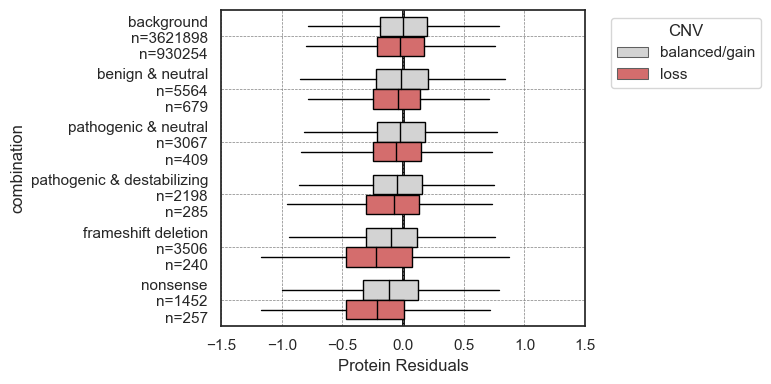

In [45]:
order = ['background', 
         'benign & neutral', 'pathogenic & neutral', 'pathogenic & destabilizing', 
         'frameshift deletion', 'nonsense']
group_counts_bg = dat_omics_mt[dat_omics_mt['CNV']=='balanced/gain']['combination'].value_counts()
group_counts_loss = dat_omics_mt[dat_omics_mt['CNV']=='loss']['combination'].value_counts()

# custom y-tick labels based on order
custom_yticks = [f'{label}\nn={group_counts_bg[label]}\nn={group_counts_loss[label]}' for label in order]

# Create a figure and axes object
fig, ax = plt.subplots(figsize=(8, 4))

ax.axvline(x=0, color='black', linestyle='-', linewidth=2, zorder=0)

# Define a color palette
color_palette = {'balanced/gain': 'lightgrey', 'loss': '#e55c5c'}

# Create a boxplot with the order of groups
sns.boxplot(y='combination', x='residuals', hue='CNV', color='black', data=dat_omics_mt, ax=ax,
            showfliers=False, width=0.75, order=order, palette=color_palette,
            boxprops=dict(edgecolor="black", linewidth=1),
            medianprops=dict(color="black", linewidth=1),
            whiskerprops=dict(color="black", linewidth=1), 
            capprops=dict(linestyle="none"))

# Set the title and labels of the plot
#plt.ylabel()
plt.xlabel('Protein Residuals')

plt.xlim(-1.5, 1.5)
#plt.ylim(2.6, -0.6)

# Set custom x-tick labels with the number of observations in each group
ax.set_yticklabels(custom_yticks)

# Customize grid
ax.grid(which='major', linestyle='--', linewidth='0.5', color='gray')
ax.grid(which='minor', linestyle='--', linewidth='0.5', color='lightgray')

plt.legend(title='CNV', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['svg.fonttype'] = 'none'
figure_path = os.path.join(
    full_path_figures, f"stability_D_{vep_cat}_{correlation_cutoff}_extended.pdf"
)
plt.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight')

plt.show()